In [125]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Notebook demo of semantic segmentation

In [126]:
# Import the relevant packages
from pathlib import Path
from PIL import Image

import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models
from torchvision.io import read_image
from torchvision import transforms, datasets
from torchvision.utils import draw_segmentation_masks
import torchvision.transforms.functional as F

In [127]:
# A helper function for plotting the images
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 10))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

## Single cat image example

### Import and pre-process the image

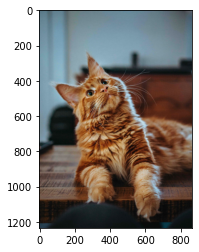

In [128]:
# Load the image
image = Image.open(Path("data") / "cat.jpg")
plt.imshow(image)
plt.show()

In [129]:
# Pre-process our input image
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
input = preprocess(image).unsqueeze(0)

# Check the input shape is (batch_size, channels, height, width)
input.shape

torch.Size([1, 3, 1234, 867])

### Load the model

In [130]:
# Check if gpu is available or use cpu to allocate memory for the tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the deeplab v3 model in evaluation mode - set pre-trained = True
dlab_model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

### Run model inference

In [131]:
# Get the model output
output = dlab_model(input)["out"]

In [132]:
# Check the output shape is (batch_size, num_classes, height, width)
output.shape

torch.Size([1, 21, 1234, 867])

In [133]:
# Load in the pre-trained classes of the model
sem_classes = [
    "__background__",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
]
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}

In [134]:
# Let's check the classes
sem_class_to_idx

{'__background__': 0,
 'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20}

### Derive the probability and boolean masks

In [135]:
# Normalise the mask into a [0,1] range with softmax
normalized_masks = torch.nn.functional.softmax(output, dim=1)

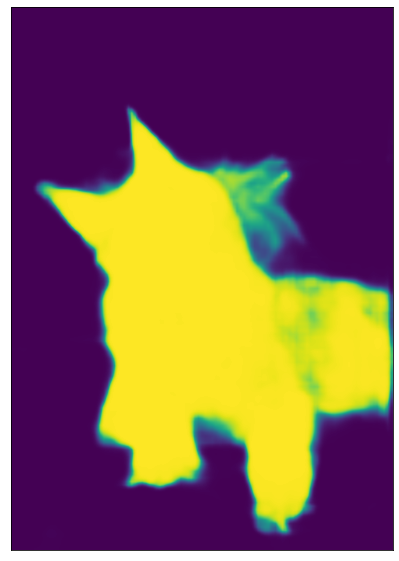

In [136]:
# Show the probability mask for the 'cat' class
probability_mask = normalized_masks[0, sem_class_to_idx["cat"]]
show(probability_mask.float())

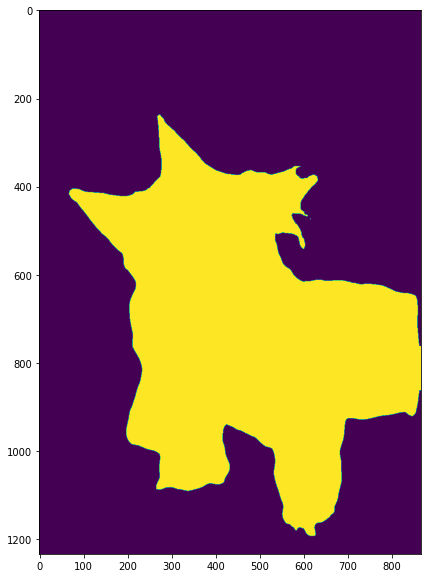

In [137]:
# Get the boolean mask
boolean_mask = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
boolean_mask.astype(bool)

plt.figure(figsize=(10, 10))
plt.imshow(boolean_mask)

### Additional step - overlay the mask on the original image

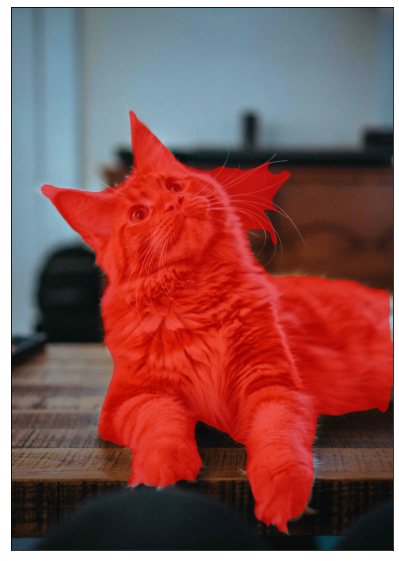

In [138]:
# Get a boolean mask for further plotting - including just the cat class
class_dim = 1
boolean_mask = output.argmax(class_dim) == sem_class_to_idx["cat"]

# Load the original image tensor
cat_int = read_image(str(Path("data") / "cat.jpg"))

# Plot the mask over the original image
overlaid_mask = draw_segmentation_masks(
    cat_int, masks=boolean_mask, alpha=0.6, colors="red"
)
show(overlaid_mask)

## Model inference with a batch of images and multiple classes

### Load data with PyTorch's ImageFolder and create an iterable

In [142]:
# Load the data into a PyTorch dataset and apply the transformations
dataset = datasets.ImageFolder(str(Path("data")), transform=preprocess)

# Wrap an iterable around the dataset
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2)

In [143]:
class_dim = 1
num_classes = 21

# Run model inference on the batch
for inputs, _ in dataloader:
    inputs = inputs.to(device)
    outputs = dlab_model(inputs)["out"]
    # Normalise the masks into a [0,1] range with softmax
    # normalized_masks = torch.nn.functional.softmax(outputs, dim=1)

# Find the argmax of all classes
all_classes_masks = (
    outputs.argmax(class_dim) == torch.arange(num_classes)[:, None, None, None]
)

# The first dimension is the classes now, so we need to swap it with the batch_size
all_classes_masks = all_classes_masks.swapaxes(0, 1)

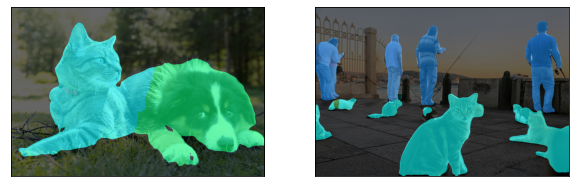

In [144]:
# Load the original images as tensors and stack them
image_1_tensor = read_image(str(Path("data/test") / "cat_dog.jpg"))
image_2_tensor = read_image(str(Path("data/test") / "cats_humans.jpg"))
image_tensors_for_visualisation = torch.stack([image_1_tensor, image_2_tensor])

# Plot the masks over the original images
images_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.6)
    for img, mask in zip(image_tensors_for_visualisation, all_classes_masks)
]
show(images_with_masks)